In [101]:
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Dict
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tabula
import os 

In [102]:
#Loading .env file
load_dotenv()

True

In [103]:
# Groq related Global variables
groq_api_key=os.getenv("Groq_API_Key")
groq_temperature=os.getenv("Groq_Temperature")
groq_model_name=os.getenv("Groq_Model_Name")

# Ollama related Global variables
ollama_embedding_model_name=os.getenv("Ollama_Embedding_Model_Name")
ollama_model_temperature=os.getenv("Ollama_Embedding_Model_Temperature")

# printing the values
# print("Groq api keys : ",groq_api_key)
# print("Groq temperature : ",groq_temperature)
# print("Groq_model_name : ",groq_model_name)

# print("Ollama model name : ",ollama_embedding_model_name)
# print("Ollama model temperature : ",ollama_model_temperature)

In [104]:
# Pydantic Class
class LLM_Structured_Output(BaseModel):
    answer:str=Field("This key contain the answer provided by the llm based on the provided context.")
    confidence:int=Field("This key contain how much confidence llm have on the provided output.")
    risk_level:Literal["Low","Medium","High"]=Field("This key contain the risk in the provided answer for taking decision.")
    decision:Literal["Show answer","Show Warning","Block Answer","Ask user to rephrase."]=Field("This key is for the decision of the LLM for showing, warning, blocking and rephrasing the the answer.")
    warning_message:str=Field("This key contain the warning given by the model if there is not any warnong then put 'None' in it.")

In [105]:
# creating the state 
class ai_monitoring_state(TypedDict):
    query:str
    context:str
    PDFFile_path:str

    texual_loaded_data:str
    tabular_loaded_data:str
    image_loaded_data:str
    texual_splitted_data:str
    tabular_splitted_data:str
    image_splitted_data:str
    ollama_embedding_model:any
    texual_vs:any
    texual_retriever_context:str

    main_prompt:str

    llm_answer:Dict
    sources:str

In [106]:
parser = PydanticOutputParser(
    pydantic_object=LLM_Structured_Output
)

print("This is parser : ",parser)

This is parser :  pydantic_object=<class '__main__.LLM_Structured_Output'>


In [107]:
# LLM model getting here 
model=ChatGroq(model=groq_model_name,temperature=groq_temperature)
print("This is model : ",model)

This is model :  profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True} client=<groq.resources.chat.completions.Completions object at 0x000002E8F7F83510> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002E8F7E41D50> model_name='openai/gpt-oss-120b' temperature=0.4 model_kwargs={} groq_api_key=SecretStr('**********')


In [108]:
query="What are the seven wonders in the india?"
prompt = PromptTemplate(
    template="""
        You must answer ONLY in valid JSON.
        Do not add explanation or text outside JSON.

        {format_instructions}

        Question:
        {query}
    """,
    input_variables=["query"],
    partial_variables={
        "format_instructions": parser.get_format_instructions()
    }
)


In [109]:
chain=prompt|model|parser

In [110]:
output=chain.invoke({"query":query})

In [111]:
print(output.answer)
print(output.confidence)
print(output.risk_level)
print(output.decision)
print(output.warning_message)

The commonly cited "Seven Wonders of India" include: 1) Taj Mahal (Agra), 2) Great Living Chola Temples (Tamil Nadu), 3) Hampi (Karnataka), 4) Khajuraho Group of Monuments (Madhya Pradesh), 5) Konark Sun Temple (Odisha), 6) Elephanta Caves (Maharashtra), and 7) Victoria Memorial (Kolkata).
85
Low
Show answer
None


In [112]:
# Creating the Document Loader node
def Texual_Data_Loader(state:ai_monitoring_state):
    texual_loader=PyPDFLoader(file_path=state["PDFFile_path"])
    texual_loaded_data=texual_loader.load()
    return {"texual_loaded_data":texual_loaded_data}

def Tabular_Data_Loader(state:ai_monitoring_state):
    tfs = tabula.read_pdf(
        state["PDFFile_path"],
        pages="all"
    )
    if tfs:
        return {'tabular_loaded_data':tfs[0]}
    else:
        return {'tabular_loaded_data':'none'}

In [113]:
# Creating the text splitter node
def Textual_Data_Splitter(state: ai_monitoring_state):
    textual_data = state["texual_loaded_data"]
    splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
    texts = splitter.split_documents(textual_data)
    return {"texual_splitted_data": texts}

In [114]:
# Node for Embedding of the texual document
def Texual_Data_Embedding(state: ai_monitoring_state):
    emb=OllamaEmbeddings(model=ollama_embedding_model_name)
    return {"ollama_embedding_model":emb}

In [115]:
# Node for texual data in the vectorstoring 
def Texual_VectorStore(state: ai_monitoring_state):
    tvs=FAISS.from_documents(state['texual_splitted_data'],state['ollama_embedding_model'])
    return {'texual_vs':tvs}

In [116]:
# node for the texual data retriever
def Texual_VectorStoreRetriever(state:ai_monitoring_state):
    vs=state["texual_vs"]
    retriever=vs.as_retriever(search_type="mmr", search_kwargs={"k": 6, "lambda_mult": 0.25})
    out=retriever.invoke(state['query'])
    return {'texual_retriever_context':out}

In [124]:
# Node the llm answer generation
def LLM_model_call(state:ai_monitoring_state):
    
    texual_context_data="".join([i.page_content for i in state['texual_retriever_context']])

    promtp_template=PromptTemplate(
        template="""
            You are the excellent output generator.
            your main work is provide the clean, polished, professional and in day to day enlgish of the user query based on the provided context.
            below is the user query and context:
            user query : {query}
            context : {context}
        """
    )

    state['main_prompt']=promtp_template.invoke({
        'query':state['query'],
        'context':texual_context_data
    })

    output=model.invoke(state['main_prompt'])

    return {"llm_answer":output}    

In [125]:
graph=StateGraph(ai_monitoring_state)

In [126]:
graph.add_node("Texual_Data_Loader",Texual_Data_Loader)
graph.add_node("Textual_Data_Splitter",Textual_Data_Splitter)
graph.add_node("Texual_Data_Embedding",Texual_Data_Embedding)
graph.add_node("Texual_VectorStore",Texual_VectorStore)
graph.add_node("Texual_VectorStoreRetriever",Texual_VectorStoreRetriever)
graph.add_node('LLM_model_call',LLM_model_call)

In [127]:
graph.add_edge(START,"Texual_Data_Loader")
graph.add_edge("Texual_Data_Loader","Textual_Data_Splitter")
graph.add_edge("Textual_Data_Splitter","Texual_Data_Embedding")
graph.add_edge("Texual_Data_Embedding","Texual_VectorStore")
graph.add_edge("Texual_VectorStore","Texual_VectorStoreRetriever")
graph.add_edge("Texual_VectorStoreRetriever",'LLM_model_call')
graph.add_edge('LLM_model_call',END)

In [128]:
workflow=graph.compile()

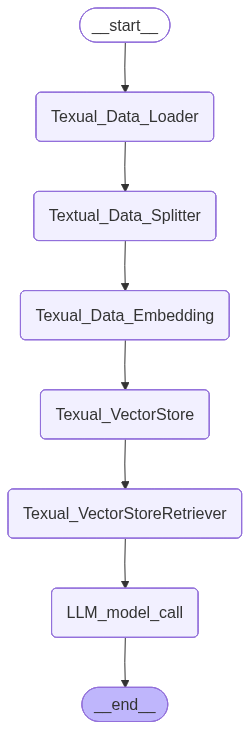

In [129]:
workflow

In [130]:
output=workflow.invoke(
    {
        "PDFFile_path":"../Input-Document/bh1.pdf",
        "query":"What is summery of the document?"
    }
)

In [134]:
output['llm_answer'].content

'**Summary**\n\nThe document outlines several strategic initiatives and reporting guidelines for the upcoming fiscal periods:\n\n1. **Reporting Frequency** – Financial statements will be filed quarterly rather than monthly, with a reporting horizon limited to one year.\n\n2. **Travel & Connectivity** – Enhancements are planned to improve ease of travel and connectivity to key tourist destinations.\n\n3. **Voluntary Disclosure** – A new provision allows parties to voluntarily declare material facts after clearance and duty assessment.\n\n4. **Grameen Credit Score** – Introduction of a “Grameen Credit Score” framework designed to support credit documentation and assessment.\n\n5. **Manuscript Heritage** – A program for the documentation and conservation of manuscript heritage is being established.\n\n6. **Financial Projections** – Projected figures (presumably revenue or a related metric) for the fiscal years are:\n\n| Fiscal Year | Projected Value |\n|-------------|-----------------|\n|

In [131]:
output['query']

'What is summery of the document?'

In [132]:
for i in output['texual_retriever_context']:
    print(i.page_content)

limit to 1 year and file quarterly statement instead of monthly.
Ease of travel and connectivity to 
tourist destinations
Page 5
new provision for voluntary declaration of material facts post clearance and duty
‘Grameen Credit Score’ framework to serve the credit
Documentation and conservation 
of our manuscript heritage to cover
2021-22 2022-23 2023-24 2024-25
(RE)
2025-26
(BE)
17.06
18.65
20.65
22.76
25.60
15
18
21
24
27
